In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('../data/Modelar_UH2022.csv', sep = '|')
data.head()

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0


In [3]:
columns = data.columns
columns

Index(['ID', 'SAMPLETIME', 'READINGINTEGER', 'READINGTHOUSANDTH',
       'DELTAINTEGER', 'DELTATHOUSANDTH'],
      dtype='object')

In [4]:
data.isna().sum(axis = 0)

ID                        0
SAMPLETIME                0
READINGINTEGER            0
READINGTHOUSANDTH    140056
DELTAINTEGER              0
DELTATHOUSANDTH      140056
dtype: int64

In [5]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')

In [6]:
data = pd.DataFrame(imputer.fit_transform(data))

In [7]:
data.columns= columns

In [8]:
def num_digitos_parte_entera(n):
    if n == 0:
        return 1
    i=0
    while n > 0:
        n//=10
        i+=1
    return i

In [9]:
data['READING'] = [j+(i/num_digitos_parte_entera(i)) for (j,i) in zip(data['READINGINTEGER'].values, data['READINGTHOUSANDTH'].values)]
data['DELTA'] = [j+(i/num_digitos_parte_entera(i)) for (j,i) in zip(data['DELTAINTEGER'].values, data['DELTATHOUSANDTH'].values)]


In [10]:
data_0 = data[data['ID']==0]

In [11]:
data_0 = data_0.drop(['READINGINTEGER', 'READINGTHOUSANDTH','DELTAINTEGER', 'DELTATHOUSANDTH'], axis=1)

In [12]:
data_0['SAMPLETIME'] = list(pd.to_datetime(data_0['SAMPLETIME'].values, format = "%Y-%m-%d %H:%M:%S"))
data_0 = data_0.set_index('SAMPLETIME')
#datos = datos.rename(columns={'x': 'y'})
#datos = datos.asfreq('MS')
data_0 = data_0.sort_index()
data_0.head()

,ID,READING,DELTA
SAMPLETIME,,,
2019-02-01 00:39:36,0,331710.0,0.0
2019-02-01 01:39:36,0,331710.0,0.0
2019-02-01 02:39:35,0,331710.0,0.0
2019-02-01 03:39:35,0,331710.0,0.0
2019-02-01 04:39:35,0,331710.0,0.0


In [13]:
data_0 = data_0.drop(['ID'], axis = 1)

In [14]:
data_0.size

17518

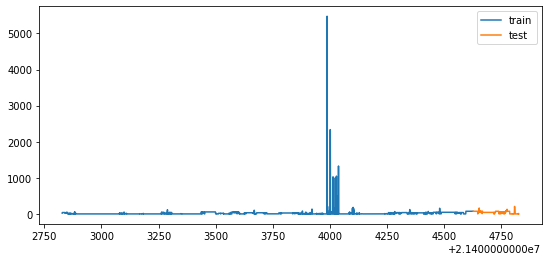

In [15]:
import matplotlib.pyplot as plt

steps = 2000
datos_train = data[:-steps]
datos_test  = data[-steps:]

datos_test1 = datos_test[:-200]
datos_test2 = datos_test[-200:]

fig, ax = plt.subplots(figsize=(9, 4))
datos_test1['DELTA'].plot(ax=ax, label='train')
datos_test2['DELTA'].plot(ax=ax, label='test')
ax.legend();

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [36]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [10, 20]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['DELTA'][-1000:],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 10,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(1000*0.5),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 12


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [07:59<00:00, 239.51s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 345.8491927380563



In [32]:
regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )
forecaster.fit(y=datos_train['DELTA'][-100:])

In [33]:
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

21402828    37.702934
21402829    37.680289
21402830    37.464151
21402831    37.059546
21402832    37.726195
Name: pred, dtype: float64

In [34]:
predicciones.value_counts()

37.642403    1993
37.702934       1
37.680289       1
37.464151       1
37.059546       1
37.726195       1
34.680806       1
37.500346       1
Name: pred, dtype: int64

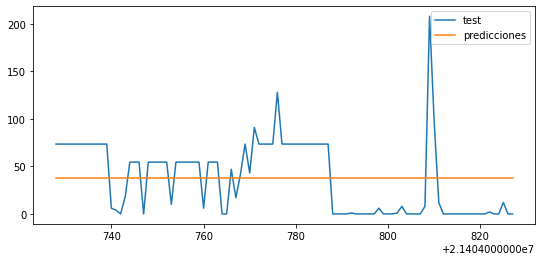

In [35]:
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train['DELTA'].plot(ax=ax, label='train')
datos_test['DELTA'][-100:].plot(ax=ax, label='test')
predicciones[-100:].plot(ax=ax, label='predicciones')
ax.legend();